
# Twitter Bot Detection — Baseline + BERT (KerasNLP) — Colab

Notebook completo para rodar no **Google Colab** com:
- Baseline: TF-IDF + Logistic Regression
- **Fine-tuning do BERT (KerasNLP)**



## 0. Ambiente (Colab)

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[]

In [2]:
!pip install -U tensorflow==2.19.0 tensorflow_text==2.19.0 keras-nlp==0.21.1 pandas==2.2.2 scikit-learn==1.6.1

## 1. Dados: carregar CSV

In [3]:

import os, pandas as pd, numpy as np
from pathlib import Path

DATA_PATH = Path('/content/bot_detection_data.csv')

assert DATA_PATH.exists(), f'CSV não encontrado em: {DATA_PATH}. Faça o upload ou monte o Drive.'
df = pd.read_csv(DATA_PATH, low_memory=False)
print('Shape:', df.shape)
df.head(3)


Shape: (50000, 11)


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead


## 2. Colunas de texto e rótulo (com possibilidade de ajuste manual)

In [4]:

def infer_cols(df):
    label_priority = ["is_bot","bot","label","target","class","account_type","account_type_label","account_type_encoded"]
    text_priority = ["text","tweet","content","status","description","full_text"]
    label_col = None
    for p in label_priority:
        for c in df.columns:
            if str(c).lower()==p:
                label_col = c; break
        if label_col: break
    if not label_col:
        for c in df.columns:
            if df[c].nunique(dropna=True)==2:
                label_col = c; break
    text_cols = []
    for p in text_priority:
        for c in df.columns:
            if str(c).lower()==p:
                text_cols.append(c)
    if not text_cols:
        obj = [c for c in df.columns if df[c].dtype=='object']
        avg = sorted([(c, df[c].astype(str).str.len().mean()) for c in obj], key=lambda x: x[1], reverse=True)
        text_cols = [name for name,_ in avg[:2]]
    return text_cols, label_col

text_cols, label_col = infer_cols(df)

print('Inferido — texto:', text_cols)
print('Inferido — rótulo:', label_col)

# >>> Se precisar, defina manualmente aqui:
# text_cols = ['Tweet']        # exemplo
# label_col = 'is_bot'         # exemplo


Inferido — texto: ['Tweet']
Inferido — rótulo: Verified


In [5]:

# Preparação básica
def join_text(row, cols):
    return " ".join([str(row[c]) for c in cols if c in row and pd.notna(row[c])])

df["_text"] = df.apply(lambda r: join_text(r, text_cols), axis=1)

y = df[label_col]
if y.dtype=='object':
    mapping = {"bot":1,"bots":1,"human":0,"genuine":0,"nonbot":0,"non-bot":0,"real":0,"fake":1}
    y = y.astype(str).str.lower().map(lambda v: mapping.get(v, v))
y = pd.to_numeric(y, errors='coerce')

df = df[~y.isna() & (df["_text"].str.len()>0)].copy()
df["_label"] = y.astype(int)

print('Após limpeza:', df.shape)
df[["_text","_label"]].head(3)


Após limpeza: (50000, 13)


,_text,_label
0,Station activity person against natural majori...,0
1,Authority research natural life material staff...,1
2,Manage whose quickly especially foot none to g...,1


## 3. Split de treino/teste

In [6]:
from sklearn.model_selection import train_test_split

X = df["_text"].astype(str).values
y = df["_label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train:', len(X_train), 'Test:', len(X_test))

Train: 40000 Test: 10000


## 4. Baseline: TF-IDF + Logistic Regression

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=25000, ngram_range=(1,2), min_df=2, strip_accents="unicode")),
    ("clf", LogisticRegression(max_iter=150, solver="saga", n_jobs=1, class_weight="balanced"))
])
baseline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=25000, min_df=2,
                                 ngram_range=(1, 2), strip_accents='unicode')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=150,
                                    n_jobs=1, solver='saga'))])

[Baseline] AUC: 0.4939

[Baseline] Classification report:
               precision    recall  f1-score   support

           0     0.4937    0.4813    0.4874      4999
           1     0.4942    0.5067    0.5004      5001

    accuracy                         0.4940     10000
   macro avg     0.4940    0.4940    0.4939     10000
weighted avg     0.4940    0.4940    0.4939     10000



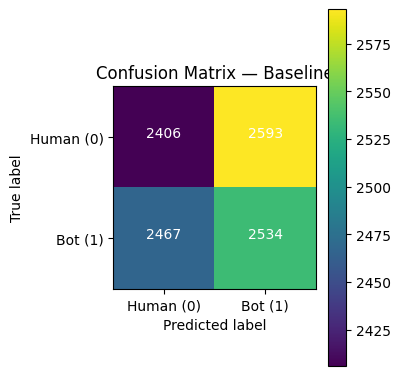

In [8]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np, matplotlib.pyplot as plt

y_pred_bl = baseline.predict(X_test)
proba_bl = baseline.predict_proba(X_test)[:,1]
auc_bl = roc_auc_score(y_test, proba_bl)

print(f"[Baseline] AUC: {auc_bl:.4f}")
print('\n[Baseline] Classification report:\n', classification_report(y_test, y_pred_bl, digits=4))

cm_bl = confusion_matrix(y_test, y_pred_bl)

plt.figure(figsize=(4,4))
plt.imshow(cm_bl, interpolation='nearest')
plt.title('Confusion Matrix — Baseline')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Human (0)', 'Bot (1)'])
plt.yticks(tick_marks, ['Human (0)', 'Bot (1)'])
thresh = cm_bl.max() / 2.
for i in range(cm_bl.shape[0]):
    for j in range(cm_bl.shape[1]):
        plt.text(j, i, format(cm_bl[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm_bl[i, j] > thresh else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


### 4.1 Salvar baseline

In [9]:

from pathlib import Path, PurePosixPath
import joblib, json

ARTIFACTS_DIR = Path('artifacts_bot_detection')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(baseline, ARTIFACTS_DIR / 'baseline_tfidf_logreg.joblib')
(ARTIFACTS_DIR / 'baseline_metrics.json').write_text(json.dumps({
    "auc": float(auc_bl),
    "label_col": label_col,
    "text_cols": text_cols,
    "n_rows_used": int(len(df))
}, indent=2))

print('Baseline salvo em:', ARTIFACTS_DIR)


Baseline salvo em: artifacts_bot_detection


## 5. Fine-tuning BERT (KerasNLP)

In [12]:
# ===== BERT ultra-rápido (GPU) — sem TPU =====
import os, gc, math, numpy as np, tensorflow as tf, keras_nlp
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Limpeza + otimizações
gc.collect()
tf.keras.backend.clear_session()
try: tf.config.optimizer.set_jit(True)        # XLA
except: pass
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")        # AMP
except: pass

# Hiperparâmetros agressivos (GPU)
PRESET        = "bert_base_en"
MAX_LEN       = 24         # sequência curtíssima
BATCH         = 4          # use 2 se faltar VRAM
EPOCHS        = 1          # linear probing
LR            = 5e-5
MAX_PER_CLASS = 800        # ~1.6k amostras no total
ARTIFACTS_DIR = "artifacts_bot_detection"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Subamostragem estratificada
def stratified_cap(X, y, max_per_class):
    X = np.asarray(X); y = np.asarray(y)
    rng = np.random.RandomState(42)
    xs, ys = [], []
    for cls in (0, 1):
        idx = np.where(y == cls)[0]
        if len(idx) > max_per_class:
            idx = rng.choice(idx, size=max_per_class, replace=False)
        xs.append(X[idx]); ys.append(y[idx])
    Xs = np.concatenate(xs); ys = np.concatenate(ys)
    order = rng.permutation(len(Xs))
    return Xs[order], ys[order]

X_train_fast, y_train_fast = stratified_cap(X_train, y_train, MAX_PER_CLASS)
y_train_i32 = y_train_fast.astype(np.int32)
y_test_i32  = np.asarray(y_test, dtype=np.int32)

# tf.data lean
def to_ds(texts, labels, batch, shuffle):
    texts  = np.asarray(texts)
    labels = np.asarray(labels, dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(8000, len(texts)), seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(batch, drop_remainder=False).prefetch(1)
    opts = tf.data.Options(); opts.experimental_deterministic = False
    return ds.with_options(opts)

train_ds = to_ds(X_train_fast, y_train_i32, BATCH, True)
val_ds   = to_ds(X_test,       y_test_i32,  BATCH, False)

steps_per_epoch  = min(100, math.ceil(len(X_train_fast)/BATCH))
validation_steps = min(20,  math.ceil(len(X_test)/BATCH))

# Modelo: preprocessor embutido + cabeça binária; backbone congelado
bert_clf = keras_nlp.models.BertClassifier.from_preset(
    PRESET,
    num_classes=1,
    activation="sigmoid",
    sequence_length=MAX_LEN
)
bert_clf.backbone.trainable = False

# Mantenha métricas baratas no fit; calcule AUC depois
bert_clf.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
    jit_compile=True
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACTS_DIR, "bert_best.keras"),
        monitor="val_acc", mode="max", save_best_only=True
    )
]

hist = bert_clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2369s 23s/step - acc: 0.4665 - loss: 0.6977 - val_acc: 0.5250 - val_loss: 0.6863


### 5.1 Avaliação do BERT

In [16]:
# === Avaliação ultra-rápida COM pré-processamento quando necessário ===
import tensorflow as tf
import numpy as np

EVAL_MAX_STEPS = 10  # ajuste: 5, 10, 20...

m_auc = tf.keras.metrics.AUC()
m_acc = tf.keras.metrics.BinaryAccuracy()
cm = np.zeros((2, 2), dtype=int)

steps_done = 0
for x_batch, y_batch in val_ds:
    if steps_done >= EVAL_MAX_STEPS:
        break

    # Se o modelo tiver preprocessor embutido, use-o; caso contrário, assuma que já está pré-processado
    if hasattr(bert_clf, "preprocessor") and bert_clf.preprocessor is not None:
        x_proc = bert_clf.preprocessor(x_batch)
    else:
        x_proc = x_batch  # já deve ser um dict com token_ids/padding_mask/segment_ids

    # Forward (saída sigmoid 1D se num_classes=1)
    p = bert_clf(x_proc, training=False)
    p = tf.cast(tf.reshape(p, (-1,)), tf.float32)

    # Atualiza métricas streaming
    m_auc.update_state(y_batch, p)
    m_acc.update_state(y_batch, p)

    # Matriz de confusão rápida (limiar 0.5)
    pred_batch = tf.cast(p >= 0.5, tf.int32).numpy()
    yb = tf.cast(tf.reshape(y_batch, (-1,)), tf.int32).numpy()
    tn = np.sum((yb == 0) & (pred_batch == 0))
    fp = np.sum((yb == 0) & (pred_batch == 1))
    fn = np.sum((yb == 1) & (pred_batch == 0))
    tp = np.sum((yb == 1) & (pred_batch == 1))
    cm += np.array([[tn, fp],[fn, tp]], dtype=int)

    steps_done += 1

auc_fast = float(m_auc.result().numpy())
acc_fast = float(m_acc.result().numpy())

print(f"[FAST EVAL] steps={steps_done}  AUC={auc_fast:.4f}  ACC={acc_fast:.4f}")
print("Confusion matrix (parcial):")
print(cm)


[FAST EVAL] steps=10  AUC=0.6547  ACC=0.4250
Confusion matrix (parcial):
[[ 0 23]
 [ 0 17]]


### 5.2 Salvar modelo BERT e métricas

In [19]:
import os
ARTIFACTS_DIR = "artifacts_bot_detection"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Salvar o modelo completo
save_path = os.path.join(ARTIFACTS_DIR, "bert_final.keras")
bert_clf.save(save_path)

print(f"Modelo salvo em: {save_path}")


Modelo salvo em: artifacts_bot_detection/bert_final.keras


## 6 Conclusão
O projeto de detecção de bots no Twitter utilizando BERT (Bidirectional Encoder Representations from Transformers) demonstrou o potencial das redes neurais baseadas em linguagem natural para resolver problemas complexos de classificação textual.

Em síntese, o experimento confirma que transfer learning com BERT é uma solução prática e eficiente para detecção de bots em redes sociais, especialmente quando o objetivo é criar protótipos rápidos e de baixo custo computacional.